# Lab 6: Pretrained Critic

## Starter Code

In [1]:
!git clone https://github.com/Damowerko/ese2000-dynamical-systems.git
import sys
if sys.path[-1] != "./ese2000-dynamical-systems/":
    sys.path.append('./ese2000-dynamical-systems/')
from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track, Track
from ese2000_dynamical.simulator import Simulator, dynamics_ca

from pathlib import Path
import matplotlib.style
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from IPython.core.display_functions import clear_output
import os

matplotlib.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.dpi"] = 150

data_path = Path("./ese2000-dynamical-systems/data")
figure_path = Path("figures")

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

x_expert = torch.Tensor(np.load(data_path / "states.npy")).float().to(device)
x_sample = x_expert[5]
simulator = Simulator()
sim_weight_A = torch.Tensor(simulator.A).to(device)
sim_weight_B = torch.Tensor(simulator.B).to(device)
track = load_track(data_path / "track.npz")

def plot_vs_expert(x, x_label: str, x_expert, track: Track):
    plt.figure()
    track.plot()
    plt.grid(True)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
    plt.plot(x[:, 0], x[:, 1], "-", label=x_label)
    plt.legend(loc="upper right", framealpha=1.0)

fatal: destination path 'ese2000-dynamical-systems' already exists and is not an empty directory.


### Interpolate Trajectory
We need to linearly interpolate the expert trajectory for stability during training

In [2]:
def interpolate_trajectory(trajectory, amount):
    """

    :param trajectory: The trajectory to interpolate
    :param amount: The amount of points to interpolate between each of the trajectory states
    :return: The expert trajectory with `amount` points linearly interpolated between each trajectory state
    """
    new_trajectory = []
    for i, point in enumerate(trajectory):
        average = (trajectory[(i + 1) % trajectory.shape[0]] + trajectory[i]) / 2
        new_trajectory.append(trajectory[i])
        new_trajectory.append(average)
    if amount == 1:
        return torch.stack(new_trajectory)
    return interpolate_trajectory(torch.stack(new_trajectory), amount - 1)

expert_sample = interpolate_trajectory(x_sample, 2)

## Load pretrained critic model

In [3]:
critic = torch.jit.load("./models/q_model.pth", map_location=device).to(device)

## Create Policy

**Your policy must accept tensors of dimension `(batch_size, STATE_LOOK_AHEAD_DIM)`**


In [4]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(STATE_LOOK_AHEAD_DIM, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 2)
        init.uniform_(self.fc4.weight, a=-1e-6, b=1e-6)

    def forward(self, normalized_state_look_ahead):
        x = normalized_state_look_ahead
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x

In [5]:
if os.path.exists("./models/policy_model.pth"):
    policy  = torch.jit.load("./models/policy_model.pth").to(device)
    print("Model already trained and loaded from file 'models/policy_model.pth'")
    print("If you would like to retrain your model, delete './models' and run this cell again.")
else:
    policy = Policy().to(device)

Model already trained and loaded from file 'models/policy_model.pth'
If you would like to retrain your model, delete './models' and run this cell again.


**We encapsulate the policy model with the Actor class to abstract some functions that make learning easier**. Feel free to inspect `Actor.py` for more details.

In [6]:
# TODO: Please inspect the Actor.py file. Look at how the policy model is encapsulated with the `Actor` class as well as all the global variables that are defined at the top.
from Actor import *

In [7]:
actor = Actor(policy, expert_sample)

## Define Rollout Policy Function

In [8]:
def rollout(actor, expert_sample, truncate_distance=1, max_timesteps=250, random_start=True):
    predicted_trajectory = []
    # normalized policy states with look ahead
    policy_states = []
    # normalized policy actions
    policy_actions = []
    state = expert_sample[0].unsqueeze(0)
    if random_start:
        state = expert_sample[
            int(torch.rand(1).item() * expert_sample.shape[0])].unsqueeze(0)
    predicted_trajectory.append(state)
    for t in range(max_timesteps - 1):
    
        normalized_action, state_with_look_ahead_normalized = actor.act(state)
        action = normalized_action * ACTION_SCALE
        
        policy_states.append(state_with_look_ahead_normalized)
        policy_actions.append(normalized_action)
        
        next_state = state.detach() @ sim_weight_A.T + action.detach() @ sim_weight_B.T
        predicted_trajectory.append(next_state)
        
        if get_closest_point(state, expert_sample)[0] > truncate_distance:
            break
            
        state = next_state
    
    policy_states = torch.stack(policy_states).squeeze(1)
    policy_actions = torch.stack(policy_actions).squeeze(1)
    predicted_trajectory = torch.stack(predicted_trajectory).squeeze(1).detach()
    
    return policy_states, policy_actions, predicted_trajectory

## Train

Episode 1	 Policy loss: 14.819985389709473	 Trajectory size: 250


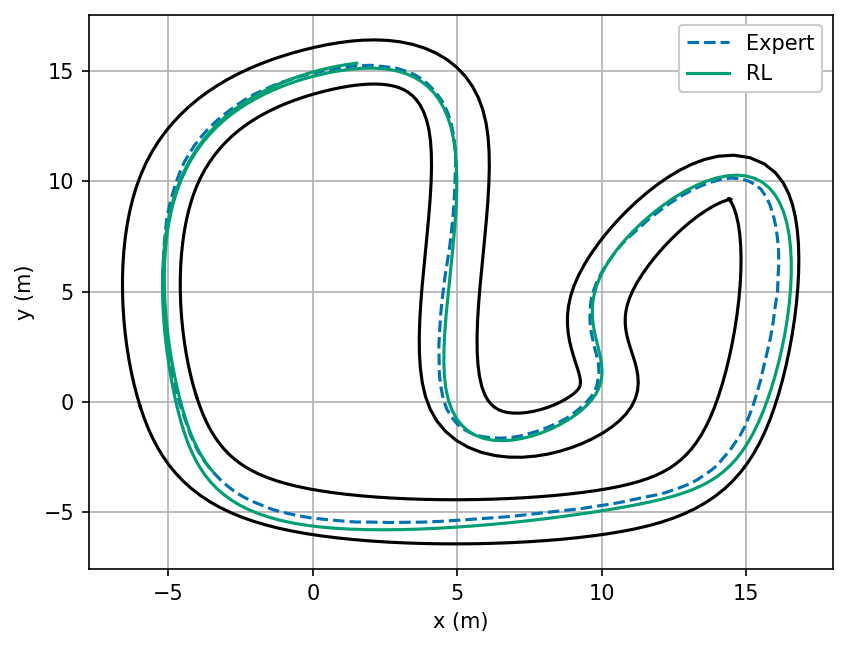

  0%|          | 16/10000 [00:11<1:55:59,  1.43it/s]


KeyboardInterrupt: 

In [9]:
from tqdm import trange

torch.set_printoptions(precision=3)
episodes = 10_000
gamma = 0.99
policy_loss = 0
policy_opt = torch.optim.Adam(policy.parameters(), lr=2e-5, maximize=True)
policy.train()
for episode in trange(episodes):

    policy_opt.zero_grad()
    
    (policy_states,
     policy_actions,
     predicted_trajectory) = rollout(actor, expert_sample)

    policy_loss = torch.mean(critic(policy_states, policy_actions))
    policy_loss.backward()
    policy_opt.step()

    if episode % 100 == 0:
        clear_output()
        print(f'Episode {episode+1}\t Policy loss: {policy_loss}\t Trajectory size: {predicted_trajectory.shape[0]}')
        plot_vs_expert(predicted_trajectory.cpu().numpy(), 'RL', x_sample.detach().cpu().numpy() , track)
        plt.show()

## Evaluate

In [ ]:
_, _, predicted_trajectory = critic.run_policy(policy, random_start=False)
plot_vs_expert(predicted_trajectory.cpu().numpy(), 'RL', x_sample.detach().cpu().numpy() , track)
plt.show()